In [145]:
import os
from skimage import io
import matplotlib.pyplot as plt
import zarr
import numpy as np

# import cv2

### All Paths

In [141]:
# RAW_PATH = '../../../../data/cells/raw/train/'
INSTANCES_PATH = '../../../../data/cells/raw/masks'
MASK_KEY = '_instances'
EXTENSION = '.tif'
# ZARR_PATH = '../../../../data/cells/raw/all.zarr'
ZARR_FOLDER = '../../../../data/cells/raw/zarr/'
RAW = 'raw'
MASK = 'mask'
GT = 'ground_truth'
PREDICTION = 'prediction'
os.listdir(RAW_PATH)

['ND8_DIV0+4h_20x_noConfinment_6_ch_4_instances.tif',
 'ND8_DIV0+4h_20x_noConfinment_6_ch_4.tif',
 '20072019_ND9_ND11_DIV0-1_Daam1_aTub_Phallo_1_ch_4_instances.tif',
 '20072019_ND9_ND11_DIV0-1_Daam1_aTub_Phallo_1_ch_4.tif']

In [142]:
def readImg(path):
    print('Reading image: {}'.format(path))
    im = io.imread(path)
    return im

def generate_pairs(folder_path):
    print(folder_path)
    files = os.listdir(folder_path)
    pairs = {}
    for f in files:
        if f.endswith(EXTENSION):
            if MASK_KEY in f:
                inp_img = f.replace(MASK_KEY,'')
                if inp_img in files:
                    pairs[os.path.join(folder_path,inp_img)]=os.path.join(folder_path,f)
#                     pairs.append({os.path.join(folder_path,inp_img):os.path.join(folder_path,f)})
                else:
                    print('ERROR! {} not found'.format(inp_img))
    print("Found {} pairs.".format(len(pairs)))
    return pairs

def getFiles(instances_path,base_name):
    files = []
    for f in os.listdir(instances_path):
        if base_name in f:
            files.append(os.path.join(instances_path,f))
    return files

def getListImages(files,shape):
    result = np.zeros(shape, dtype=np.int32) 
    for i,f in enumerate(files):
        tmp = readImg(f)
        result[:,:,i] = tmp
    return result

def normalize_mask(mask,list_vals):
    size = list_vals.size
    shape = (mask.shape+tuple([size]))
    result = np.zeros(shape, dtype=np.float32)
    for i in range(size):
        tmp = np.zeros_like(mask)
        tmp [mask == list_vals[i]] = 1.0
        result[:,:,i] = tmp
    return result

def get_base_name(path):
    base = os.path.basename(path)
    return os.path.splitext(base)[0]

def normalize_image(img):
    img = img.astype(np.float32)
    img = img / 255.
    return img

In [144]:
def create_one_big_zarr(raw_path,zar_path):
    pairs = generate_pairs(raw_path)
    size = len(pairs)
    root = zarr.open(zar_path, mode='w')
    initial = True
    for i,(image_path, mask_path) in enumerate(pairs.items()):
        print(i)
        im_image = readImg(image_path)
        im_mask = readImg(mask_path)
        if(initial):
            # removed the last value because it is the error category
            mask_values = np.unique(im_mask)[:4]
            shape_image = (tuple([size])+im_image.shape)
            shape_mask = (tuple([size])+im_mask.shape+tuple([mask_values.size]))
            print('The value to be activated in mask: {} '.format(mask_values))
            print('Img size: {} {} | Mask size: {} {}'.format(shape_image,type(im_image),shape_mask,type(im_mask)))
            root.zeros(RAW, shape=shape_image, chunks=(1,256, 256,1), dtype='f')
            root.zeros(GT, shape=shape_mask, chunks=(1,256, 256,1), dtype='f')
            initial = False
        
        normalized_mask = normalize_mask(im_mask,mask_values)
        print('The normalized mask: {} '.format(normalized_mask.shape))
        root[RAW][i] = im_image
        root[GT][i] = normalized_mask
    
    
def create_zarr_per_pair(raw_path,instances_path,zarr_path):
    pairs = generate_pairs(raw_path)
    size = len(pairs)
    for i,(image_path, mask_path) in enumerate(pairs.items()):
        base_name = get_base_name(image_path)
        list_masks = getFiles(instances_path,base_name)
        zarr_file = os.path.join(zarr_path,base_name+'.zarr')   
        print('{} - {}'.format(i,zarr_file))
        root = zarr.open(zarr_file, mode='w')
        im_image = readImg(image_path)
        im_mask = readImg(mask_path)
        
        # removed the last value because it is the error category
        mask_values = np.unique(im_mask)[:4]
        shape_image = im_image.shape
        shape_mask = (im_mask.shape+tuple([mask_values.size]))
        shape_instances =  (im_mask.shape+tuple([3]))
        print('The value to be activated in mask: {} '.format(mask_values))
        print('Img size: {} {} < {} | Mask size: {} {} <{}'.format(shape_image,im_image.dtype,im_image.max()
                                                                   ,shape_mask,im_mask.dtype,im_mask.max()))
        root.zeros(RAW, shape=shape_image, chunks=(256, 256,1), dtype='f8')
        root.zeros(GT, shape=shape_mask, chunks=(256, 256,1), dtype='f8')
#         root.zeros(PREDICTION, shape=shape_mask, chunks=(256, 256,1), dtype='f8')
        root.zeros(MASK, shape=shape_instances, chunks=(256, 256,1), dtype='i8')
        nomalized_image = normalize_image(im_image)
        normalized_mask = normalize_mask(im_mask,mask_values)
        instances_images = getListImages(list_masks,shape_instances)
        print('After normalization: Img size: {} {} <{} | Mask size: {} {} <{}'.format(nomalized_image.shape,nomalized_image.dtype,nomalized_image.max(),
                                                                                       normalized_mask.shape,normalized_mask.dtype,normalized_mask.max()))
        root[RAW] = nomalized_image
        root[GT] = normalized_mask
        root[MASK] = instances_images
        
create_zarr_per_pair(RAW_PATH,INSTANCES_PATH,ZARR_FOLDER)
# create_zarr(RAW_PATH,ZARR_PATH)

../../../../data/cells/raw/train/
Found 2 pairs.
0 - ../../../../data/cells/raw/zarr/ND8_DIV0+4h_20x_noConfinment_6_ch_4.zarr
Reading image: ../../../../data/cells/raw/train/ND8_DIV0+4h_20x_noConfinment_6_ch_4.tif
Reading image: ../../../../data/cells/raw/train/ND8_DIV0+4h_20x_noConfinment_6_ch_4_instances.tif
The value to be activated in mask: [0. 4. 5. 6.] 
Img size: (1024, 1024, 4) uint8 < 255 | Mask size: (1024, 1024, 4) float32 <13.0
Reading image: ../../../../data/cells/raw/masks/ND8_DIV0+4h_20x_noConfinment_6_ch_4_1_409.tif
Reading image: ../../../../data/cells/raw/masks/ND8_DIV0+4h_20x_noConfinment_6_ch_4_2_369.tif
Reading image: ../../../../data/cells/raw/masks/ND8_DIV0+4h_20x_noConfinment_6_ch_4_0_383.tif
After normalization: Img size: (1024, 1024, 4) float32 <1.0 | Mask size: (1024, 1024, 4) float32 <1.0
1 - ../../../../data/cells/raw/zarr/20072019_ND9_ND11_DIV0-1_Daam1_aTub_Phallo_1_ch_4.zarr
Reading image: ../../../../data/cells/raw/train/20072019_ND9_ND11_DIV0-1_Daam1_aTu

In [126]:
# plt.imshow(bg)

In [114]:
ZARR_PATH = '../../../../data/cells/raw/zarr/ND8_DIV0+4h_20x_noConfinment_6_ch_4.zarr'
file = zarr.open(ZARR_PATH, mode='r')

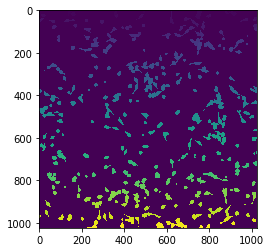

In [115]:
plt.imshow(file[MASK][:,:,2])

In [116]:
file[MASK].shape

(1024, 1024, 3)

In [117]:
file[MASK].dtype

dtype('int32')